In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark
from pathlib import Path

spark = get_spark(cores=4, app_name="masking-notebook")
display(spark)

root = Path("~/shared/plantclef/data").expanduser().as_posix()
display(root)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/01 03:41:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/01 03:41:52 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


'/storage/home/hcoda1/8/amiyaguchi3/shared/plantclef/data'

In [3]:
path = f"{root}/masking/test_2024_v2/data"
print(path)
df = spark.read.parquet(path).cache()
df.printSchema()
%time display(df.count())
df.show(n=5)

/storage/home/hcoda1/8/amiyaguchi3/shared/plantclef/data/masking/test_2024_v2/data
root
 |-- image_name: string (nullable = true)
 |-- leaf_mask: binary (nullable = true)
 |-- flower_mask: binary (nullable = true)
 |-- plant_mask: binary (nullable = true)
 |-- sand_mask: binary (nullable = true)
 |-- wood_mask: binary (nullable = true)
 |-- tape_mask: binary (nullable = true)
 |-- tree_mask: binary (nullable = true)
 |-- rock_mask: binary (nullable = true)
 |-- vegetation_mask: binary (nullable = true)
 |-- sample_id: integer (nullable = true)



1695

CPU times: user 6.73 ms, sys: 1.14 ms, total: 7.88 ms
Wall time: 3.21 s


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|          image_name|           leaf_mask|         flower_mask|          plant_mask|           sand_mask|           wood_mask|           tape_mask|           tree_mask|           rock_mask|     vegetation_mask|sample_id|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+
|CBN-PdlC-B4-20190...|[78 9C EC D8 BD A...|[78 9C EC DD B1 B...|[78 9C EC DD BF B...|[78 9C EC DC BB A...|[78 9C EC DD CD 8...|[78 9C EC D9 BD 8...|[78 9C EC DD BF B...|[78 9C EC D9 B1 A...|[78 9C EC DD BF B...|        4|
|CBN-PdlC-F1-20160...|[78 9C EC C8 31 0...|[78 9C EC DA 31 6...|[78 9C EC DB CD A...|[78 9C EC DB CD A...|[78 9C

In [4]:
rows = df.sample(fraction=0.1, seed=42).limit(20).collect()
len(rows)

20

(2868, 2816)


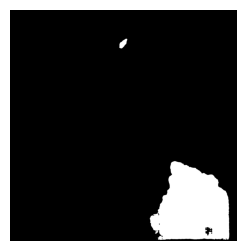

In [5]:
from plantclef.serde import deserialize_mask
import pandas as pd
from matplotlib import pyplot as plt
from plantclef.morph.plotting import plot_mask, plot_mask_stats
from plantclef.morph.stats import mask_mean, mask_num_components


row = rows[0]
mask = deserialize_mask(row["leaf_mask"])
print(mask.shape)
plot_mask(mask)
plt.show()

In [6]:
# see how the number of connected components decrease with erosion and dilation
display(mask_mean(mask), mask_num_components(mask))

0.08627614567484468

8

In [30]:
# let's try opening and closing a bunch of times and see how it changes over time
from tqdm import tqdm
from plantclef.morph.workflow import generate_mask_stats

stats = generate_mask_stats(mask, tqdm(range(5, 101, 5)))
pdf = pd.DataFrame(stats)
display(pdf)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


,iteration,opening_mean,opening_num_components,closing_mean,closing_num_components,opening_closing_mean,opening_closing_num_components
0,5,0.086386,8,0.086215,3,0.086347,2
1,10,0.086707,5,0.086002,2,0.086644,2
2,15,0.086912,3,0.085787,2,0.086770,2
3,20,0.087282,2,0.085651,2,0.087075,2
4,25,0.088487,2,0.085272,2,0.088220,2
5,30,0.089568,2,0.085007,2,0.089218,2
6,35,0.090183,2,0.084412,2,0.089814,2
7,40,0.090304,2,0.084064,2,0.089804,2
8,45,0.090352,2,0.083421,1,0.089372,1
9,50,0.090375,2,0.083283,1,0.089372,1


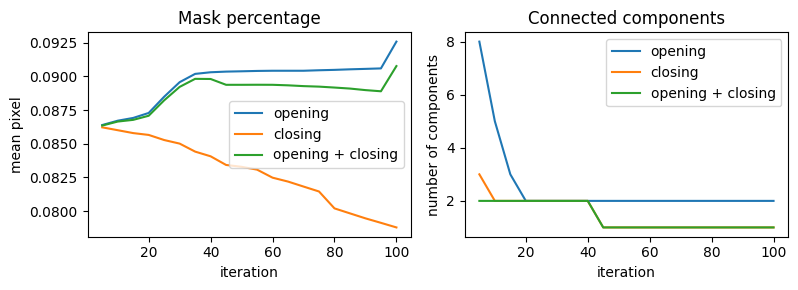

In [27]:
plot_mask_stats(pdf)
plt.show()

CPU times: user 464 ms, sys: 0 ns, total: 464 ms
Wall time: 464 ms


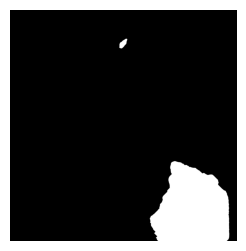

CPU times: user 462 ms, sys: 4.98 ms, total: 467 ms
Wall time: 468 ms


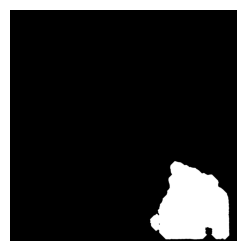

CPU times: user 873 ms, sys: 12.9 ms, total: 886 ms
Wall time: 888 ms


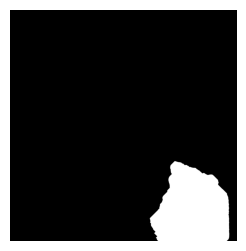

In [28]:
%time plot_mask(opening(mask, 50))
plt.show()
%time plot_mask(closing(mask, 50))
plt.show()
%time plot_mask(closing(opening(mask, 50), 50))
plt.show()